In [33]:
import sys
import pandas as pd
import os
from alibi_detect.cd import ChiSquareDrift, TabularDrift, MMDDrift
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as ss

sys.path.append("../..")

from drift_detector.explainer import Explainer
from drift_detector.experiments import *
from gemini.constants import *
from drift_detector.plotter import errorfill, plot_roc, plot_pr, linestyles, markers, colors, brightness, colorscale
from gemini.legacy_utils import import_dataset, import_dataset_hospital, FEATURES
from gemini.utils import run_synthetic_shift_experiment
from baseline_models.static.utils import run_model

### Load data ###

In [3]:
(X_tr, y_tr), (X_val, y_val), (X_t, y_t), orig_dims = import_dataset('los',shuffle=True,)
(X_t_1, y_t_1) = apply_shift(X_tr, y_tr, X_t, y_t, 'small_gn_shift_0.1')

### Plot ###

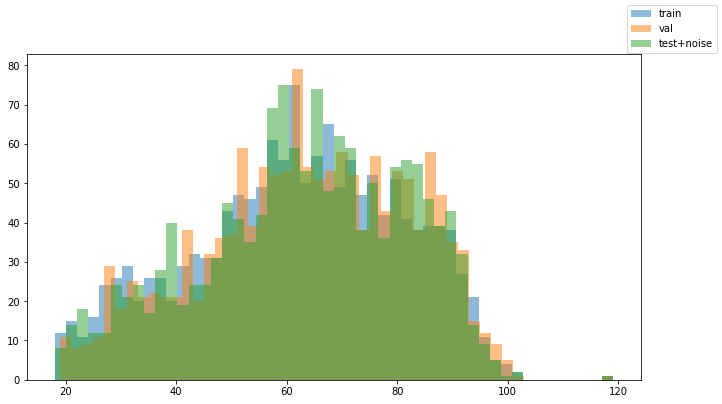

In [4]:
fig, ax = plt.subplots(figsize=(11, 6))
plt.hist(X_tr[:,0], bins=50, alpha=0.5,label='train')
plt.hist(X_val[:,0], bins=50, alpha=0.5, label='val')
plt.hist(X_t_1[:,0], bins=50, alpha=0.5 , label='test+noise')
fig.legend(loc='upper right')
plt.show()

### KS Test ###

In [50]:
test_hosp='UHNTG'
train_hosp='SMH'
(X_tr, y_tr), (X_val, y_val), (X_t, y_t), orig_dims = import_dataset_hospital('los',[HOSPITAL_ID[train_hosp]],[HOSPITAL_ID[test_hosp]],FEATURES)
sample = X_val.shape[0]
cd = TabularDrift(X_val, p_val=.05)
preds = cd.predict(X_t[0:sample,])
labels = ['No!', 'Yes!']
pvals = preds['data']['p_val']
feat_rank = ss.rankdata(pvals)
print('Drift? {}'.format(labels[preds['data']['is_drift']]))
print('\nTop Drifted Features:')
for i in range(0,len(pvals)):
    i = int(i)
    if i == 3:
        break
    n = i+1
    feat_index = np.where(feat_rank == n)[0][0]
    print('   {} P-value: {}'.format(FEATURES[feat_index],pvals[feat_index]))


Drift? No!

Top Drifted Features:
   icd10_C00_D49 P-value: 0.010368011891841888
   age P-value: 0.01837289333343506
   icd10_D50_D89 P-value: 0.1129155084490776


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


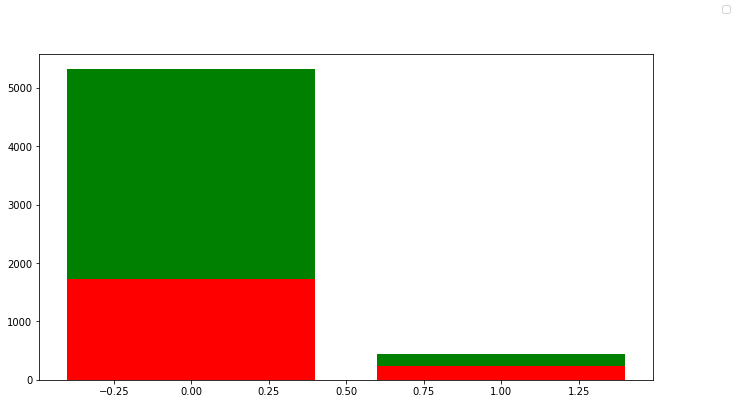

In [31]:
label = 'los'
feat_index = np.where(feat_rank == 1)[0][0]
fig, ax = plt.subplots(figsize=(11, 6))
if FEATURES[feat_index] == "age":
    plt.hist(X_tr[:,feat_index], bins=50, alpha=0.5,label=train_hosp)
    plt.hist(X_val[:,feat_index], bins=50, alpha=0.5, label=train_hosp)
    plt.hist(X_t[0:sample,feat_index], bins=50, alpha=0.5 , label=test_hosp)
else:
    #fig.add_axes([0,1])
    X_tr = pd.concat([pd.DataFrame(X_tr,columns=FEATURES),pd.DataFrame(y_tr,columns=['los'])],axis=1)
    X_tr_pos = X_tr.loc[X_tr[label] == 1]
    plt.bar([0,1],np.bincount(X_tr[FEATURES[feat_index]]),color='g')
    plt.bar([0,1],np.bincount(X_tr_pos[FEATURES[feat_index]]),color='r')
  #  X_val = pd.concat([pd.DataFrame(X_val,columns=FEATURES),pd.DataFrame(y_val,columns=['los'])],axis=1)
  #  X_val_pos = X_val.loc[X_val[label] == 1]
  #  plt.bar([0,1],np.bincount(X_val[FEATURES[feat_index]]))
    X_t = pd.concat([pd.DataFrame(X_t,columns=FEATURES),pd.DataFrame(y_t,columns=['los'])],axis=1)
    X_t_pos = X_t.loc[X_t[label] == 1]  
    plt.bar([0,1],np.bincount(X_t[FEATURES[feat_index]]),color='g')
    plt.bar([0,1],np.bincount(X_t_pos[FEATURES[feat_index]]),color='r')
    #'LOS ',"LOS > 7 days"
fig.legend(loc='upper right')
plt.show()

### MMD ###

In [53]:
cd = MMDDrift(X_val, backend='pytorch', p_val=.05,)
preds = cd.predict(X_t[0:sample,])
print('Drift? {} P-value: {}'.format(labels[preds['data']['is_drift']],preds['data']['p_val']))

No GPU detected, fall back on CPU.
Drift? Yes! P-value: 0.0
